In [9]:
### 单均柴油加油量影响因子分析
### CompetingStationsPrice_AvgVolumeFactor
# 结论1：加油总升数（无论柴or汽）都与最终销量强相关98%+
# 结论2：单均柴油加油量，一定有不知名的影响因子，以至于我们无法预测。并且这个影响因子应该与某些可公开的信息（如活动）相关，因为它还在一定程度上影响了站前流量


In [10]:
### STEP1：读取数据 ###
import pandas as pd

COLS_DATE = 'date'
COLS_PRICE = '60000313_price'                   #92号国六B
COLS_PRICE_OTHER = '60000313_price_other'
COLS_ORDER_CNT = '60000313_order_cnt'
COLS_AMOUNT = '60000313_amount'  
COLS_LITERS = '60000313_refuelLiters'
COLS_PER_LITERS = '60000313_per_cnt_refuelLiters'
# 车流量
COLS_CAR_FLOW_QI = '站前车流量（汽油）'
COLS_CAR_FLOW_CHAI = '站前车流量（柴油）'
COLS_ALL = [COLS_DATE, 
            COLS_PRICE, COLS_PRICE_OTHER, COLS_AMOUNT, COLS_ORDER_CNT, COLS_LITERS, 
            COLS_CAR_FLOW_QI, COLS_CAR_FLOW_CHAI
            ]


# 读取excel文件并获取指定列
df = pd.read_csv('../Data/竞争站分析-竞争站-单站-32801309.csv', usecols=COLS_ALL, encoding='GBK')
# df2 = pd.read_csv('../Data/竞争站分析-竞争站-单站-32801817.csv', usecols=COLS_ALL, encoding='GBK')
# print(df.head())

In [11]:
### STEP2：添加特征列
import CompetingStationPrice_Utils as utils
df[COLS_PER_LITERS] = df[COLS_LITERS] / df[COLS_ORDER_CNT]
# df2[COLS_PER_LITERS] = df2[COLS_LITERS] / df2[COLS_ORDER_CNT]
df['单升加油价格'] = df[COLS_AMOUNT] / df[COLS_LITERS]
df['单升加油价格变化'] = df['单升加油价格'] - df['单升加油价格'].shift(1)
df['单升加油价格变化'] = df['单升加油价格变化'].fillna(0)

# 新列：竞争站点价格
df[COLS_PRICE_OTHER] = df[COLS_PRICE_OTHER].apply(utils.get_lowest_price)

# 新列：当前油品的差价
df['价格差'] = df[COLS_PRICE] - df[COLS_PRICE_OTHER]        # 我们比对方贵为正数， 便宜为负数
# print(df.head())

# 新列：当前油品的价格变化（相较前一日）
df['价格变化'] = df[COLS_PRICE] - df[COLS_PRICE].shift(1)
df['价格变化'] = df['价格变化'].fillna(0)

# 新列：当前油品的竞争价格变化
df['竞争站价格变化'] = df[COLS_PRICE_OTHER] - df[COLS_PRICE_OTHER].shift(1)
df['竞争站价格变化'] = df['竞争站价格变化'].fillna(0)

print(df['单升加油价格变化'].describe(percentiles=[0.1,  0.2, 0.5, 0.8 , 0.9]))

count    365.000000
mean      -0.000137
std        0.053858
min       -0.360012
10%       -0.000160
20%       -0.000095
50%       -0.000003
80%        0.000090
90%        0.000159
max        0.469904
Name: 单升加油价格变化, dtype: float64


60000313_refuelLiters与60000313_amount相关系数：
Pearson相关系数: 0.9882175095371449, p值: 5.339940811012362e-298
Spearman相关系数: 0.978673224372753, p值: 1.3268330181235407e-251
Kendall相关系数: 0.8812584675598372, p值: 2.1100579926621114e-139


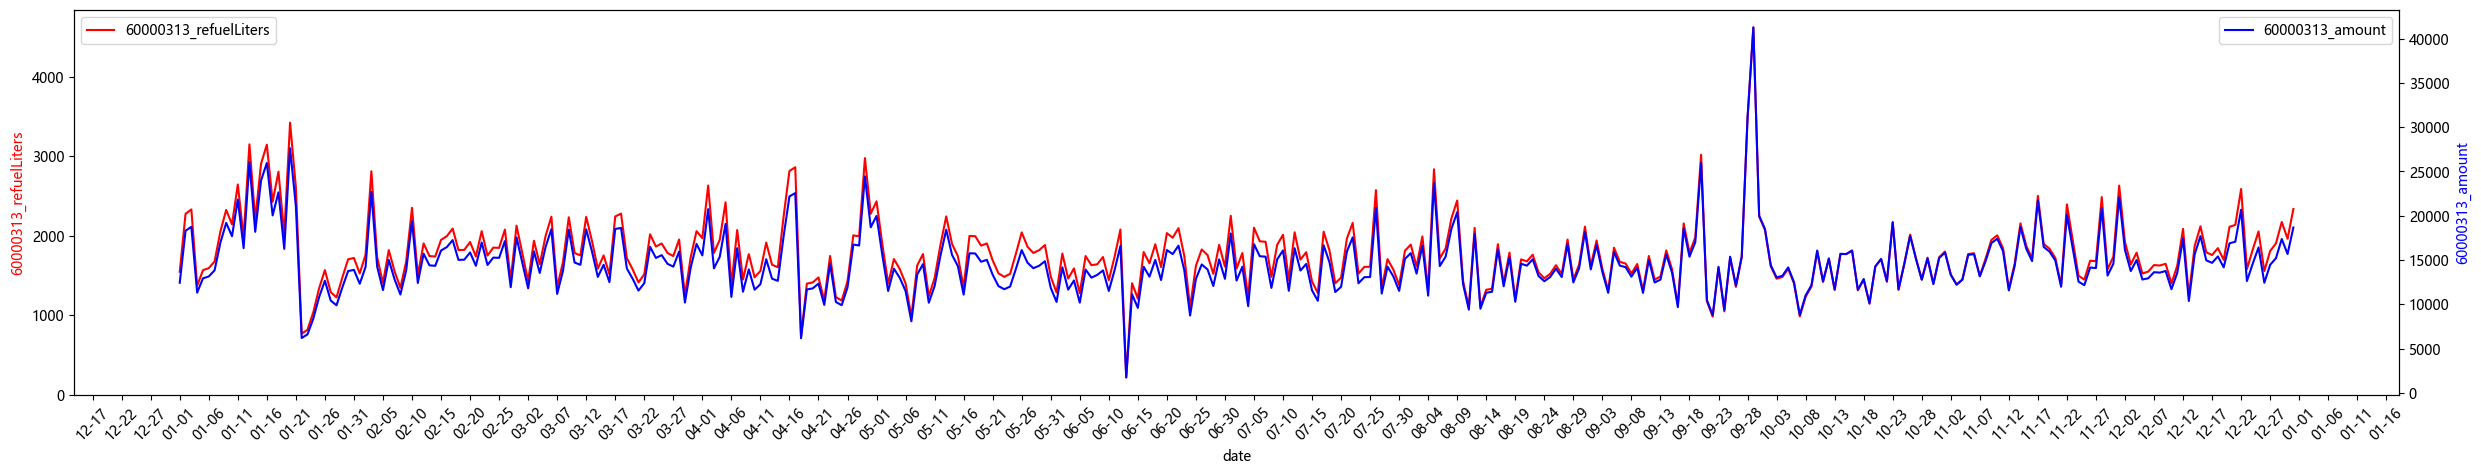

In [12]:
### STEP3：确认两者与时间的相关性

from scipy.stats import pearsonr, spearmanr, kendalltau

# 定义数据列
COLS_X = COLS_DATE
COLS_Y1 = COLS_LITERS   # 检验相关性的两列之一
COLS_Y2 = COLS_AMOUNT    # 检验相关性的两列之二

# 确保这两列没有缺失值
df_clean = df[[COLS_Y1, COLS_Y2]].dropna()

# 使用Pearson相关系数计算相关性及p值
pearson_corr, pearson_pvalue = pearsonr(df_clean[COLS_Y1], df_clean[COLS_Y2])
spearman_corr, spearman_pvalue = spearmanr(df_clean[COLS_Y1], df_clean[COLS_Y2])
kendall_corr, kendall_pvalue = kendalltau(df_clean[COLS_Y1], df_clean[COLS_Y2])

# 打印结果
print(F"{COLS_Y1}与{COLS_Y2}相关系数：")
print(f"Pearson相关系数: {pearson_corr}, p值: {pearson_pvalue}")
print(f"Spearman相关系数: {spearman_corr}, p值: {spearman_pvalue}")
print(f"Kendall相关系数: {kendall_corr}, p值: {kendall_pvalue}")

# 打印折线图
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates


# 设置字体，确保能正确显示汉字
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体

# 创建一个图表和轴对象
fig, ax1 = plt.subplots(figsize=(30,5))

# 绘制第一条曲线
ax1.plot(df[COLS_X], df[COLS_Y1], 'r-', label=COLS_Y1)
# ax1.plot(df[COLS_X], df2[COLS_Y2], 'r-', label='站点32801309')
ax1.set_xlabel(COLS_X)
ax1.set_ylabel(COLS_Y1, color='r')
date_format = mdates.DateFormatter('%m-%d')
ax1.xaxis.set_major_formatter(date_format)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5)) 
plt.xticks(rotation=45)
# fig.autofmt_xdate()


# 利用twinx()创建第二个Y轴
ax2 = ax1.twinx()

# 绘制第二条曲线
ax2.plot(df[COLS_X], df[COLS_Y2], 'b-', label=COLS_Y2)
ax2.set_ylabel(COLS_Y2, color='b')

# 显示图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 显示图表
plt.show()